# BIWENGER ANALYSIS

This script obtains the data from Biwenger and analyzes different features that could be useful to become better at this fantasy game. For example, the posibilities of one player to be on the starting eleven, the chances of getting certain players on a pack...

## Data Extraction

The data is extracted from the Biwenger website JSON, extracting, in this case, the information of LaLiga, the competition under study on this Notebook

In [69]:
import requests
import csv
import pandas as pd
import numpy as np

#Obataining the Biwenger json

#Modified:
#Change url for as+sofascore points
#r = requests.get(
#    "https://cf.biwenger.com/api/v2/competitions/la-liga/data?lang=en&score=1").json()

r = requests.get(
    "https://cf.biwenger.com/api/v2/competitions/la-liga/data?lang=en&score=5").json()


#Extracting the players data and storing it as csv

data = []
for k, v in r['data']['players'].items():
    data.append(v)

with open('output.csv', 'w', newline="", encoding="UTF-8") as f:
    writer = csv.writer(f)
    writer.writerow(v.keys())
    writer.writerows(data)
    
df = pd.DataFrame(data)
df = df.sort_values(by=['points'])
df.head()

,id,name,slug,teamID,position,price,fantasyPrice,status,priceIncrement,playedHome,playedAway,fitness,points,pointsHome,pointsAway,pointsLastSeason,statusInfo
24,15466,Álex Centelles,alex-centelles,22.0,2,170000,9000000,ok,0,0,1,"[None, None, None, None, None]",-3,0,-3,NaN,NaN
424,29637,Pierre-Gabriel,r-pierre-gabriel,7.0,2,490000,10000000,sanctioned,-20000,1,0,"[-3, None, None, None, None]",-3,-3,0,NaN,Double yellow card
131,6021,Diego López,diego-lopez,70.0,1,290000,20000000,ok,-10000,0,1,"[None, None, None, None, None]",-3,0,-3,176.0,NaN
252,23809,John Donald,john-donald,75.0,3,150000,7000000,injured,0,1,2,"[injured, injured, injured, injured, injured]",-1,3,-4,11.0,Fracture of the fibula.
0,29673,Alexander Callens,a-callens,289.0,2,1830000,15000000,ok,-150000,0,0,"[None, None, None, None, None]",0,0,0,NaN,NaN


## New:
### Save data to out.csv

In [7]:
compression_opts = dict(method='zip', archive_name='out.csv')  
df.to_csv('out.zip', index=False, compression=compression_opts)  

## Cost of Point Evaluation

Two models are created for this evaluation, one linear regression, and a grade 2 polynomial regression. As we can observe, the second degree polynomial regression fits the data a lot better than the linear one. 
The possible explanation to this would be that on the fantasy game only 11 players are allowed each matchday, so the price players which generate a large amount of points tend to increase on a non-linear way.

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#Linear Regression

X = df.loc[:, ['points']].values

y = df.loc[:, 'price'].values

model = LinearRegression(fit_intercept = True);
model.fit(X,y);

In [60]:
from sklearn.preprocessing import PolynomialFeatures

#Polynomical Regression

poly=PolynomialFeatures(degree=2,
                           include_bias = False)
X_poly=poly.fit_transform(X.reshape(-1,1))
model2 = LinearRegression();
model2.fit(X_poly, y);

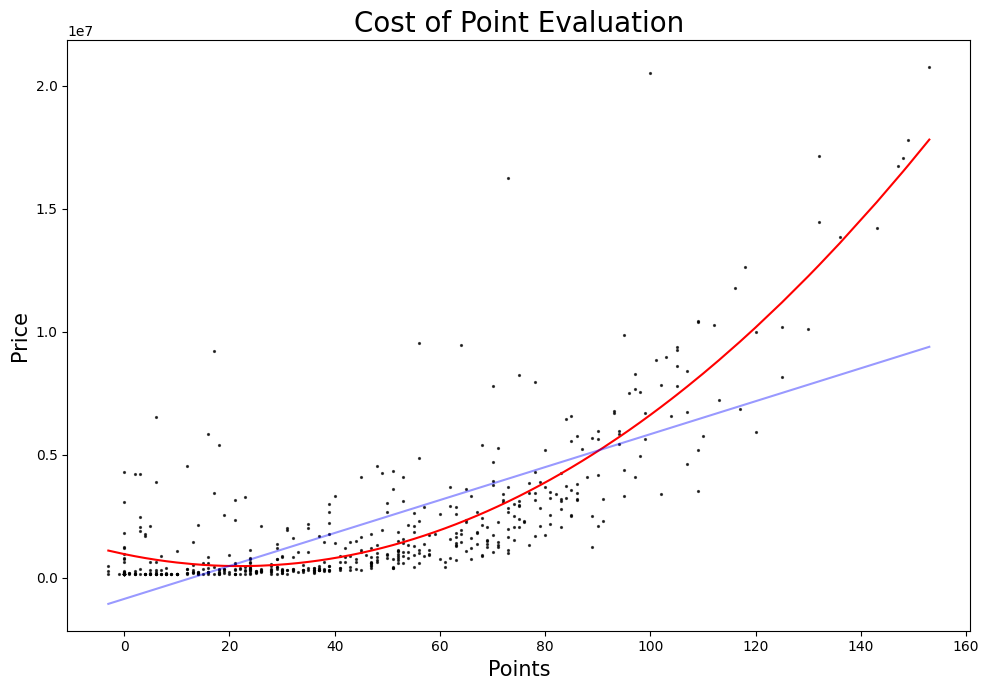

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,7));
ax.scatter(X,
           y,
           color = 'black',
           s = 1.7,
           alpha = 0.7);
ax.plot(X,
        model2.predict(X_poly),
        color = 'red');

ax.plot(X,
       model.predict(X),
       color = 'blue',
       alpha = 0.4)
ax.set_xlabel('Points',
              fontsize = 15);
ax.set_ylabel('Price',
             fontsize = 15);
ax.set_title('Cost of Point Evaluation',
             fontsize = 20)
fig.tight_layout()

## Testing different methods to predict price

### Based on single variable (points)

In [105]:
#Split data:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, ['points']],df.loc[:, ['price']],random_state=0)

#KNeighbors
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor(n_neighbors=4).fit(X_train, y_train)
print("Test set prediction:", reg.predict(X_test)[5], "\n", "Real value:", y_test.iloc[5])
print("Train set R^2: {:.2f}".format(reg.score(X_train, y_train)))
print("Test set R^2: {:.2f}".format(reg.score(X_test, y_test)))

print("\n")

#Linear regression test:
lr=LinearRegression(fit_intercept = True).fit(X_train,y_train)
print("Parameters:", lr.coef_, lr.intercept_)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))
print("Test set prediction example:", lr.predict(X_test)[5], "\n", "Real values:", X_test.iloc[5].values, y_test.iloc[6].values)

#

print("\n")

#Parabolic regression test
poly=PolynomialFeatures(degree=2, include_bias = False)
X_poly=poly.fit_transform(X_train.values.reshape(-1,1))
poly_reg_model = LinearRegression();
pb=poly_reg_model.fit(X_poly,y_train)
print("Parameters:", pb.coef_, pb.intercept_)
print("Training set score: {:.2f}".format(pb.score(X_poly, y_train)))
print("Test set score: {:.2f}".format(pb.score(poly.fit_transform(X_test.values.reshape(-1,1)), y_test)))
print("Test set prediction example:", pb.predict(poly.fit_transform(X_test.values.reshape(-1,1)))[5], "\n", "Real values:", X_test.iloc[5].values, y_test.iloc[5].values)

Test set prediction: [440000.] 
 Real value: price    360000
Name: 12, dtype: int64
Train set R^2: 0.78
Test set R^2: 0.66


Parameters: [[64002.43092011]] [-708257.399441]
Training set score: 0.53
Test set score: 0.52
Test set prediction example: [1211815.52816236] 
 Real values: [30] [5970000]


Parameters: [[-40959.28033772    971.0776022 ]] [931099.13388278]
Training set score: 0.72
Test set score: 0.73
Test set prediction example: [576290.5657346] 
 Real values: [30] [360000]


### Based on multi-variable (points, matches, average, fitness results, fitness average, status)

## Profitability based on cost of point

In [93]:

var = model2.predict(X_poly)-y
maximum = max(var)
minimum = min(var)

df = df.assign(profitability = 2*((var-minimum)/(maximum-minimum))-1)
df.head()

best_profitability = df.sort_values(by = 'profitability',ascending = False)
count = 1
for i in best_profitability.head(10)['name'].values:
    print("{}: {}".format(count,i))
    count += 1

1: Berenguer
2: Maffeo
3: Fernando Martinez
4: Juan Iglesias
5: Aimar Oroz
6: Raíllo
7: Isi Palazón
8: Édgar Badía
9: Ledesma
10: Torró


## Number of Players in a Price Range

This function allows to get the % of players on a certain range of prices

In [94]:
n_players = df['price'].count()
precios = list(df['price'])

In [95]:
def rango_precios(a,b,precios):
    count = 0
    for i in range (len(precios)):
        if precios[i]>=a and precios[i]<=b:
            count = count + 1
    porcentaje = (count/len(precios))*100
    return (count, porcentaje)
    

In [96]:
porcentaje = rango_precios(150000,500000,precios)[1]
print('The percentage of players on this price interval is :', porcentaje, '%')

The percentage of players on this price interval is : 24.903474903474905 %


## Histogram of Players in a Price Range

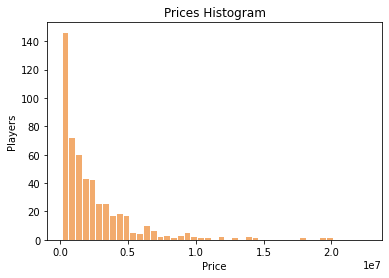

In [99]:
intervalos = range(min(precios),max(precios),500000);
plt.hist(x=precios, bins=intervalos, color='#F2AB6D', rwidth=0.85);
plt.title('Prices Histogram');
plt.xlabel('Price');
plt.ylabel('Players');

## Players with higher price increment

In [106]:
delta_max=[]
player_delta=[]
for i in range (len(df['priceIncrement'])):
    if df['priceIncrement'][i]>=80000:
        delta_max.append(df['priceIncrement'][i])
        player_delta.append(df['name'][i])
        
price_var = dict(zip(player_delta,delta_max))

In [108]:
import operator
price_var = sorted(price_var.items(),
                   key=operator.itemgetter(1),
                   reverse = True)
for i, j in price_var:
    print("{}: {} €/day".format(i,j))

Rodrygo: 160000 €/day
Nico Williams: 150000 €/day
Valverde: 130000 €/day
Berenguer: 120000 €/day
Borja Iglesias: 110000 €/day
Christensen: 100000 €/day
Tchouameni: 100000 €/day
Piqué: 90000 €/day
Brais Méndez: 80000 €/day
Lewandowski: 80000 €/day


## PACK PROBABILITIES

This script calculate the probability of unpacking a player on a scpecific range of prices when buying one of the Biwenger packs.

## Bronze Pack

In [109]:
probability = []
rango = []
n=0
p=0
bronze_players = rango_precios(0,5000000,precios)[0]
for i in range (1000000,5000001,1000000):
    z = str(i-1e6) + ' - ' + str(i)
    rango.append(z)
    n = rango_precios(i-1000000,i,precios)[0]
    p = (n/bronze_players)*100
    probability.append(p)

probabilidad = dict(zip(rango,probability))

keys = []
values = []
for key,value in probabilidad.items():
    keys.append(str(key))
    values.append(str(value))

s= dict(zip(keys,values))
d = pd.DataFrame(s, index = ['Probability (%)'])
d

,0.0 - 1000000,1000000.0 - 2000000,2000000.0 - 3000000,3000000.0 - 4000000,4000000.0 - 5000000
Probability (%),43.722943722943725,22.727272727272727,17.532467532467532,8.441558441558442,8.225108225108226


## Silver Pack

In [111]:
probability = []
rango = []
n=0
p=0
silver_players = rango_precios(5000000,10000000,precios)[0]
for i in range (6000000,10000001,1000000):
    z = str(i-1e6) + ' - ' + str(i)
    rango.append(z)
    n = rango_precios(i-1000000,i,precios)[0]
    p = (n/silver_players)*100
    probability.append(p)
    
invest_recover = probability[3]+probability[4]
print ('Probability of making profit: ',invest_recover, "%")
probabilidad = dict(zip(rango,probability))

keys = []
values = []
for key,value in probabilidad.items():
    keys.append(str(key))
    values.append(str(value))

s= dict(zip(keys,values))
d = pd.DataFrame(s, index = ['Probability (%)'])
d

Probability of making profit:  22.727272727272727 %


,5000000.0 - 6000000,6000000.0 - 7000000,7000000.0 - 8000000,8000000.0 - 9000000,9000000.0 - 10000000
Probability (%),29.545454545454547,34.090909090909086,13.636363636363635,6.8181818181818175,15.909090909090908


## Gold Pack

In [113]:
probability = []
n=0
p=0
gold_players = rango_precios(10000000,30000000,precios)[0]
for i in range (10000000,30000001,1000000):
    z = str(i-1e6) + ' - ' + str(i)
    rango.append(z)
    n = rango_precios(i-1000000,i,precios)[0]
    p = (n/gold_players)*100
    probability.append(p)

probabilidad = dict(zip(rango,probability))

keys = []
values = []
for key,value in probabilidad.items():
    keys.append(str(key))
    values.append(str(value))

s= dict(zip(keys,values))
d = pd.DataFrame(s, index = ['Probabilidad (%)'])
d

,5000000.0 - 6000000,6000000.0 - 7000000,7000000.0 - 8000000,8000000.0 - 9000000,9000000.0 - 10000000,10000000.0 - 11000000,11000000.0 - 12000000,12000000.0 - 13000000,13000000.0 - 14000000,14000000.0 - 15000000,15000000.0 - 16000000,16000000.0 - 17000000,17000000.0 - 18000000,18000000.0 - 19000000,19000000.0 - 20000000,20000000.0 - 21000000,21000000.0 - 22000000,22000000.0 - 23000000,23000000.0 - 24000000,24000000.0 - 25000000
Probabilidad (%),53.84615384615385,23.076923076923077,7.6923076923076925,15.384615384615385,7.6923076923076925,0.0,0.0,7.6923076923076925,0.0,7.6923076923076925,7.6923076923076925,0.0,0.0,7.6923076923076925,0.0,0.0,0.0,0.0,0.0,0.0


## STARTING ELEVEN CHANCES

In [114]:
from bs4 import BeautifulSoup
import urllib
import re

url = 'https://www.futbolfantasy.com/'
html = urllib.request.urlopen(url)
soup = BeautifulSoup(html)
teams = soup('a',class_ ='team')
Equipos = []
for team in teams:
    alt = team.get('alt')
    if alt not in Equipos:
        Equipos.append(alt)

### START THE CRAWLER ###

links=[]
for team in teams:
    link = team.get('href')
    if link not in links:
        links.append(link)


titulares_equipos=[]
for url2 in links:
    html2 = urllib.request.urlopen(url2)
    soup2 = BeautifulSoup(html2)
    equipo = soup2('span', class_='nombre')
    equipo = re.findall('(?<=>).*(?=<)',str(equipo))
    jug = soup2('a', class_='juggador')
    datos_jug=[]
    for i in jug:
        datos_jug.append(i.contents)
        p = re.findall('\d\d%',str(i.contents))
        n = re.findall('(?<=>).*(?=<)',str(i.contents))
        nombres_titulares = []
        for nombres in titulares_equipos:
            nombres_titulares.append(nombres[0])
        if len(n)>0:
            if n[0] not in nombres_titulares:
                if p != []:
                    z = [n[0],p[0],equipo[0]]
                    titulares_equipos.append(z)

In [122]:
df_ff = pd.DataFrame(titulares_equipos,columns=['name','Titularidad','Equipo'])
#Get the starting eleven chances:
def starting_eleven(equipo):
    for i, j, k in df_ff.get(df_ff['Equipo']==equipo).values:
        print("{}: {}".format(i,j))
    
starting_eleven('Real Madrid')

Courtois: 95%
Valverde: 50%
Mendy: 60%
Kroos: 90%
Tchouaméni: 70%
Camavinga: 60%
Benzema: 60%
Alaba: 80%
Carvajal: 70%
Vinicius: 95%
Militão: 80%
Ceballos: 50%
Rodrygo: 50%
Nacho: 50%
Rüdiger: 50%
Asensio: 30%
E. Hazard: 20%
Lucas: 10%
Odriozola: 10%


## API - SOFASCORE

### Sofascore Average Score

In [ ]:
import requests
import json
ids=[]
equipo_ids=dict()
url = "https://sofascore.p.rapidapi.com/teams/search"
Sofascore=pd.DataFrame(columns=['Jugador','Media','Equipo','ID'])
for equipo in Equipos:
    try:
        url = "https://sofascore.p.rapidapi.com/teams/search"
        querystring = {"name":equipo}
        headers = {
            'x-rapidapi-host': "sofascore.p.rapidapi.com",
            'x-rapidapi-key': "##########################################"
            }

        response = requests.request("GET", url, headers=headers, params=querystring)
        r=json.loads(response.text)

        ids.append(r['teams'][0]['id'])
        equipo_ids[equipo]=r['teams'][0]['id']

        url = "https://sofascore.p.rapidapi.com/teams/get-squad"
        for id_ in ids:

            querystring = {"teamId":id_}

            headers = {
                'x-rapidapi-host': "sofascore.p.rapidapi.com",
                'x-rapidapi-key': "##########################################"
                }

            response = requests.request("GET", url, headers=headers, params=querystring)
            r=json.loads(response.text)

            p=r['players']
            for i in range(len(p)):
                idd=p[i]['player']['id']
                player=p[i]['player']['name']
                url = "https://sofascore.p.rapidapi.com/players/get-last-ratings"

                querystring = {"playerId":idd,"tournamentId":"8","seasonId":"37223"}

                headers = {
                    'x-rapidapi-host': "sofascore.p.rapidapi.com",
                    'x-rapidapi-key': "##########################################"
                    }

                response = requests.request("GET", url, headers=headers, params=querystring)
                r=json.loads(response.text)
                ratings = r['lastRatings']
                j=0
                rates=0
                try:
                    for i in range(len(ratings)):
                        rate=ratings[i]['rating']
                        j=j+1
                        rates=rates+rate
                    media=rates/j
                    Sofascore=Sofascore.append({'Jugador':player,'Media':media,'Equipo':equipo,'ID':idd},ignore_index=True)
                except:
                    continue
    except:
        print('Error during data extraction on: ',equipo)

In [ ]:
## Show the Sofascore Dataset
Sofascore